# Laboratorio 7

## Integrantes

### Sergio Orellana - 221122

### Andre Marroquin - 22266

### Rodrigo Mansilla - 22611

# Link del repositorio

https://github.com/mar22266/LABORATORIOS-IA.git

# Link del video


# TASK 1

1. ¿Qué es el aprendizaje por diferencias temporales (Temporal Difference Learning) y en qué se diferencia de los métodos tradicionales de aprendizaje supervisado? Explique el concepto de "error de diferencia temporal" y su papel en los algoritmos de aprendizaje por refuerzo.

El aprendizaje por diferencias temporales TD es una técnica de aprendizaje por refuerzo que permite a un agente aprender a predecir valores futuros basándose en experiencias pasadas, sin necesidad de esperar una señal de recompensa final. A diferencia del aprendizaje supervisado, que requiere un conjunto de datos etiquetados para entrenar un modelo, el aprendizaje TD ajusta sus estimaciones de valor en función de la diferencia entre predicciones sucesivas a lo largo del tiempo.

El "error de diferencia temporal" es la discrepancia entre la recompensa observada más el valor estimado del siguiente estado y el valor estimado del estado actual. Este error guía la actualización de las estimaciones de valor del agente, permitiéndole mejorar sus predicciones y decisiones futuras.


2. En el contexto de los juegos simultáneos, ¿cómo toman decisiones los jugadores sin conocer las acciones de sus oponentes? Dé un ejemplo de un escenario del mundo real que pueda modelarse como un juego simultáneo y discuta las estrategias que los jugadores podrían emplear en tal situación.

En los juegos simultáneos, los jugadores deben elegir sus estrategias al mismo tiempo, sin información sobre las elecciones de los demás. Para tomar decisiones, cada jugador considera las posibles acciones de los oponentes y evalúa las mejores respuestas a esas acciones, utilizando conceptos como el equilibrio de Nash para identificar estrategias óptimas.

Un ejemplo del mundo real es la competencia entre empresas que lanzan productos similares al mercado. Sin conocer las decisiones exactas de sus competidores, cada empresa debe decidir aspectos como el precio, la calidad y las características del producto. Las estrategias pueden incluir la diferenciación del producto, la competencia en precios o la innovación para captar una mayor cuota de mercado.


3. ¿Qué distingue los juegos de suma cero de los juegos de no suma cero y cómo afecta esta diferencia al proceso de toma de decisiones de los jugadores? Proporcione al menos un ejemplo de juegos que entren en la categoría de juegos de no suma cero y discuta las consideraciones estratégicas únicas involucradas.

En los juegos de suma cero, la ganancia de un jugador es exactamente igual a la pérdida de otro; es decir, el total de ganancias y pérdidas suma cero. En contraste, en los juegos de no suma cero, es posible que todos los jugadores ganen o pierdan simultáneamente, permitiendo resultados de beneficio mutuo o perjuicio compartido.

Esta diferencia influye en la toma de decisiones: en juegos de suma cero, los jugadores suelen adoptar estrategias competitivas enfocadas en maximizar su propia ganancia a expensas del oponente. En juegos de no suma cero, las estrategias pueden ser más cooperativas, buscando soluciones que beneficien a todas las partes involucradas.

Un ejemplo de juego de no suma cero es el dilema del prisionero, donde dos sospechosos deciden independientemente si confesar o no. La cooperación no confesar puede resultar mejor para ambos, mientras que la traición mutua ambos confiesan lleva a resultados peores. Este escenario destaca la tensión entre la cooperación y la competencia en la toma de decisiones estratégicas.


4. ¿Cómo se aplica el concepto de equilibrio de Nash a los juegos simultáneos? Explique cómo el equilibrio de Nash representa una solución estable en la que ningún jugador tiene un incentivo para desviarse unilateralmente de la estrategia elegida.

El equilibrio de Nash en juegos simultáneos es una situación en la que cada jugador adopta la mejor estrategia posible, considerando las estrategias elegidas por los demás jugadores. En este equilibrio, ningún jugador puede mejorar su resultado cambiando unilateralmente su estrategia, lo que lo convierte en una solución estable.

Este concepto es fundamental en la teoría de juegos, ya que permite predecir resultados en situaciones donde los participantes toman decisiones interdependientes. En un equilibrio de Nash, cada jugador reconoce que cualquier desviación unilateral no le proporcionará un beneficio adicional, lo que fomenta la estabilidad de las estrategias adoptadas.


5. Discuta la aplicación del aprendizaje por diferencias temporales en el modelado y optimización de procesos de toma de decisiones en entornos dinámicos. ¿Cómo maneja el aprendizaje por diferencias temporales el equilibrio entre exploración y explotación y cuáles son algunos de los desafíos asociados con su implementación en la práctica?

El aprendizaje por diferencias temporales (TD) se aplica en entornos dinámicos para modelar y optimizar procesos de toma de decisiones, permitiendo a un agente aprender políticas óptimas a través de la interacción continua con el entorno. Al actualizar las estimaciones de valor basándose en experiencias recientes, el aprendizaje TD es eficaz en situaciones donde el modelo del entorno es desconocido o cambia con el tiempo.

Para equilibrar la exploración, descubrir nuevas estrategias y la explotación utilizar estrategias conocidas que ofrecen recompensas, se emplean políticas como e-greedy, donde el agente elige acciones aleatorias con una pequeña probabilidad e y, en otros casos, selecciona la acción que maximiza la recompensa esperada.

Los desafíos en la implementación práctica del aprendizaje TD incluyen la selección adecuada de la tasa de aprendizaje y el manejo de la maldición de la dimensionalidad, que se refiere al aumento exponencial de la complejidad a medida que crece el espacio de estados y acciones.


# Task 2

In [34]:
import math
import random
import copy
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import models, layers, optimizers




#### Funciones del Juego

In [35]:
# ---------------- Funciones del juego ---------------- #
def create_board():
    return [[EMPTY for _ in range(COLUMN_COUNT)] for _ in range(ROW_COUNT)]

def drop_piece(board, row, col, piece):
    board[row][col] = piece

def is_valid_location(board, col):
    return board[0][col] == EMPTY

def get_next_open_row(board, col):
    for r in range(ROW_COUNT - 1, -1, -1):
        if board[r][col] == EMPTY:
            return r
    return None

def winning_move(board, piece):
    # Horizontal
    for r in range(ROW_COUNT):
        for c in range(COLUMN_COUNT - 3):
            if (board[r][c] == piece and board[r][c+1] == piece and 
                board[r][c+2] == piece and board[r][c+3] == piece):
                return True
    # Vertical
    for c in range(COLUMN_COUNT):
        for r in range(ROW_COUNT - 3):
            if (board[r][c] == piece and board[r+1][c] == piece and 
                board[r+2][c] == piece and board[r+3][c] == piece):
                return True
    # Diagonal positiva
    for r in range(3, ROW_COUNT):
        for c in range(COLUMN_COUNT - 3):
            if (board[r][c] == piece and board[r-1][c+1] == piece and 
                board[r-2][c+2] == piece and board[r-3][c+3] == piece):
                return True
    # Diagonal negativa
    for r in range(ROW_COUNT - 3):
        for c in range(COLUMN_COUNT - 3):
            if (board[r][c] == piece and board[r+1][c+1] == piece and 
                board[r+2][c+2] == piece and board[r+3][c+3] == piece):
                return True
    return False

def get_winning_positions(board, piece):
    for r in range(ROW_COUNT):
        for c in range(COLUMN_COUNT - 3):
            if (board[r][c] == piece and board[r][c+1] == piece and 
                board[r][c+2] == piece and board[r][c+3] == piece):
                return [(r, c + i) for i in range(4)]
    for c in range(COLUMN_COUNT):
        for r in range(ROW_COUNT - 3):
            if (board[r][c] == piece and board[r+1][c] == piece and 
                board[r+2][c] == piece and board[r+3][c] == piece):
                return [(r + i, c) for i in range(4)]
    for r in range(3, ROW_COUNT):
        for c in range(COLUMN_COUNT - 3):
            if (board[r][c] == piece and board[r-1][c+1] == piece and 
                board[r-2][c+2] == piece and board[r-3][c+3] == piece):
                return [(r - i, c + i) for i in range(4)]
    for r in range(ROW_COUNT - 3):
        for c in range(COLUMN_COUNT - 3):
            if (board[r][c] == piece and board[r+1][c+1] == piece and 
                board[r+2][c+2] == piece and board[r+3][c+3] == piece):
                return [(r + i, c + i) for i in range(4)]
    return []

def get_valid_locations(board):
    valid = []
    for col in range(COLUMN_COUNT):
        if is_valid_location(board, col):
            valid.append(col)
    return valid

def is_terminal_node(board):
    return winning_move(board, 1) or winning_move(board, 2) or len(get_valid_locations(board)) == 0

# Representación del estado: one-hot
def get_state_one_hot(board):
    mapping = {0: [1, 0, 0], 1: [0, 1, 0], 2: [0, 0, 1]}
    state = []
    for row in board:
        for cell in row:
            state.extend(mapping[cell])
    return np.array(state)

def print_board(board, winning_positions=[]):
    for r in range(ROW_COUNT):
        row_str = ""
        for c in range(COLUMN_COUNT):
            cell = board[r][c]
            if (r, c) in winning_positions:
                row_str += "\033[91m" + str(cell) + "\033[0m" + " "
            else:
                row_str += str(cell) + " "
        print(row_str)
    print("")


### Algoritmo minimax


In [36]:
# ---------------- Implementación del Algoritmo Minimax ---------------- #
def minimax(board, depth, alpha, beta, maximizingPlayer, piece, use_pruning):
    valid_locations = get_valid_locations(board)
    terminal = is_terminal_node(board)
    opponent_piece = 1 if piece == 2 else 2
    if depth == 0 or terminal:
        if terminal:
            if winning_move(board, piece):
                return (None, math.inf)
            elif winning_move(board, opponent_piece):
                return (None, -math.inf)
            else:
                return (None, 0)
        else:
            return (None, score_position(board, piece))
    if maximizingPlayer:
        value = -math.inf
        best_col = random.choice(valid_locations)
        for col in valid_locations:
            row = get_next_open_row(board, col)
            b_copy = copy.deepcopy(board)
            drop_piece(b_copy, row, col, piece)
            new_score = minimax(b_copy, depth - 1, alpha, beta, False, opponent_piece, use_pruning)[1]
            if new_score > value:
                value = new_score
                best_col = col
            if use_pruning:
                alpha = max(alpha, value)
                if alpha >= beta:
                    break
        return best_col, value
    else:
        value = math.inf
        best_col = random.choice(valid_locations)
        for col in valid_locations:
            row = get_next_open_row(board, col)
            b_copy = copy.deepcopy(board)
            drop_piece(b_copy, row, col, piece)
            new_score = minimax(b_copy, depth - 1, alpha, beta, True, opponent_piece, use_pruning)[1]
            if new_score < value:
                value = new_score
                best_col = col
            if use_pruning:
                beta = min(beta, value)
                if alpha >= beta:
                    break
        return best_col, value



### Agente TD Learning


In [37]:

# Parámetros del juego y del algoritmo Q-learning
ROW_COUNT = 6
COLUMN_COUNT = 7
EMPTY = 0

# Parámetros del Q-learning (valores por defecto)
ALPHA = 0.001       # Tasa de aprendizaje (para el optimizador de la red)
GAMMA = 0.95        # Factor de descuento
EPSILON = 1.0       # Tasa de exploración inicial
EPSILON_MIN = 0.1   # Valor mínimo de epsilon
EPSILON_DECAY = 0.995  # Factor de decaimiento de epsilon por episodio

# Parámetros del modelo
INPUT_SIZE = ROW_COUNT * COLUMN_COUNT * 3  # 126, por la representación one-hot
OUTPUT_SIZE = COLUMN_COUNT  # 7 acciones (columnas)

# ---------------- Modelo de Red Neuronal ---------------- #
def build_model():
    model = models.Sequential([
        layers.Input(shape=(INPUT_SIZE,)),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(OUTPUT_SIZE, activation='linear')  # Q-values para cada acción
    ])
    model.compile(loss='mse', optimizer=optimizers.Adam(learning_rate=ALPHA))
    return model

q_model = build_model()  
# ---------------- Agente TD Learning con Modelo ---------------- #
def choose_action(state, board, epsilon):
    """
    Selecciona una acción usando política ε-greedy:
      - Con probabilidad epsilon, elige una acción aleatoria de las válidas.
      - Con probabilidad (1 - epsilon), elige la acción con mayor Q-value (filtrado por válidas).
    """
    valid_actions = get_valid_locations(board)
    if np.random.rand() < epsilon:
        return random.choice(valid_actions)
    state_input = state.reshape(1, INPUT_SIZE)
    q_values = q_model.predict(state_input, verbose=0)[0]
    q_valid = {action: q_values[action] for action in valid_actions}
    return max(q_valid, key=q_valid.get)

def update_Q(state, action, reward, next_state, done):
    """
    Actualiza el modelo usando un paso de Q-learning:
      - Calcula el target Q-value para la acción tomada.
      - Entrena la red para minimizar el error entre el Q-value predicho y el target.
    """
    state_input = state.reshape(1, INPUT_SIZE)
    next_state_input = next_state.reshape(1, INPUT_SIZE)
    q_values = q_model.predict(state_input, verbose=0)
    q_next = q_model.predict(next_state_input, verbose=0)
    target = q_values.copy()
    if done:
        target[0][action] = reward
    else:
        target[0][action] = reward + GAMMA * np.max(q_next)
    q_model.fit(state_input, target, epochs=1, verbose=0)

#The above code defines a function `simulate_game_td_vs_minimax` that simulates a game between agents using a combination of Temporal Difference Learning (TD) and Minimax algorithms. The function takes two parameters: `use_pruning` which is a boolean flag to indicate whether pruning should be used in the Minimax algorithm, and `depth` which specifies the depth of the Minimax search tree.


### Ciclo de Entrenamiento



In [38]:

# ---------------- Ciclo de Entrenamiento ---------------- #
def train_agent(episodes):
    global EPSILON, current_board
    for ep in range(episodes):
        board = create_board()
        current_board = board
        game_over = False
        turn = 0
        total_reward = 0
        while not game_over:
            state = get_state_one_hot(board)
            valid_actions = get_valid_locations(board)
            if len(valid_actions) == 0:
                game_over = True
                break
            # En self-play, ambos jugadores usan la misma política.
            action = choose_action(state, board, EPSILON)
            row = get_next_open_row(board, action)
            # Alterna turno: turno 0 -> pieza 1, turno 1 -> pieza 2
            piece = 1 if turn == 0 else 2
            drop_piece(board, row, action, piece)
            # Estructura de recompensas:
            # Si gana: +100 para la pieza 2 (agente) y -100 para la pieza 1.
            # Si es empate: 0.
            # Si no termina: -1 por movimiento.
            if winning_move(board, piece):
                reward = 100 if piece == 2 else -100
                game_over = True
            elif is_terminal_node(board):
                reward = 0
                game_over = True
            else:
                reward = -1
            total_reward += reward
            next_state = get_state_one_hot(board)
            update_Q(state, action, reward, next_state, game_over)
            turn = (turn + 1) % 2
            current_board = board
        if EPSILON > EPSILON_MIN:
            EPSILON *= EPSILON_DECAY
        print(f"Episode {ep+1}/{episodes} - Total Reward: {total_reward} - Epsilon: {EPSILON:.3f}")


### Simulación de partida entre agentes

In [39]:
# ---------------- Simulación de Partidas entre Agentes ---------------- #
def simulate_game_td_vs_minimax(use_pruning=False, depth=4):
    """
    Simula una partida entre el agente TD Learning (pieza 2) y un agente Minimax (pieza 1).
    - El agente TD Learning usa la política actual (sin exploración, epsilon=0).
    - El agente Minimax usa el algoritmo minimax, con o sin poda según 'use_pruning'.
    Devuelve: 2 si gana el TD, 1 si gana Minimax, 0 en empate.
    """
    board = create_board()
    game_over = False
    turn = 0  # Turno 0: Minimax (pieza 1), Turno 1: TD Learning (pieza 2)
    while not game_over:
        if turn == 0:
            # Agente Minimax
            col, _ = minimax(board, depth, -math.inf, math.inf, True, 1, use_pruning)
            if col is None:
                return 0  # Empate
            row = get_next_open_row(board, col)
            drop_piece(board, row, col, 1)
            if winning_move(board, 1):
                return 1
        else:
            # Agente TD Learning (usamos epsilon 0 para evaluar la política aprendida)
            state = get_state_one_hot(board)
            col = choose_action(state, board, 0.0)
            if col not in get_valid_locations(board):
                col = random.choice(get_valid_locations(board))
            row = get_next_open_row(board, col)
            drop_piece(board, row, col, 2)
            if winning_move(board, 2):
                return 2
        if is_terminal_node(board):
            return 0  # Empate
        turn = (turn + 1) % 2
    return 0

# ---------------- Modo de Evaluación: Jugar contra el agente entrenado ---------------- #
def play_game():
    board = create_board()
    game_over = False
    turn = 0
    print_board(board)
    while not game_over:
        if turn == 0:
            valid_cols = get_valid_locations(board)
            col = -1
            while col not in valid_cols:
                try:
                    col = int(input(f"Col (0-{COLUMN_COUNT-1}): "))
                    if col not in valid_cols:
                        print("No válido, intente otra vez.")
                except ValueError:
                    print("Entrada inválida.")
            row = get_next_open_row(board, col)
            drop_piece(board, row, col, 1)
            if winning_move(board, 1):
                winning_pos = get_winning_positions(board, 1)
                print_board(board, winning_pos)
                print("¡Ganaste!")
                game_over = True
            else:
                print_board(board)
        else:
            state = get_state_one_hot(board)
            col = choose_action(state, board, 0.0)  # Sin exploración
            if col not in get_valid_locations(board):
                col = random.choice(get_valid_locations(board))
            row = get_next_open_row(board, col)
            drop_piece(board, row, col, 2)
            if winning_move(board, 2):
                winning_pos = get_winning_positions(board, 2)
                print_board(board, winning_pos)
                print("IA gana.")
                game_over = True
            else:
                print_board(board)
        turn = (turn + 1) % 2

# ---------------- Modo de Evaluación: Jugar contra el agente entrenado ---------------- #
def play_game():
    board = create_board()
    game_over = False
    turn = 0
    print_board(board)
    while not game_over:
        if turn == 0:
            valid_cols = get_valid_locations(board)
            col = -1
            while col not in valid_cols:
                try:
                    col = int(input(f"Col (0-{COLUMN_COUNT-1}): "))
                    if col not in valid_cols:
                        print("No válido, intente otra vez.")
                except ValueError:
                    print("Entrada inválida.")
            row = get_next_open_row(board, col)
            drop_piece(board, row, col, 1)
            if winning_move(board, 1):
                winning_pos = get_winning_positions(board, 1)
                print_board(board, winning_pos)
                print("¡Ganaste!")
                game_over = True
            else:
                print_board(board)
        else:
            state = get_state_one_hot(board)
            col = choose_action(state, board, 0.0)  # Sin exploración
            if col not in get_valid_locations(board):
                col = random.choice(get_valid_locations(board))
            row = get_next_open_row(board, col)
            drop_piece(board, row, col, 2)
            if winning_move(board, 2):
                winning_pos = get_winning_positions(board, 2)
                print_board(board, winning_pos)
                print("IA gana.")
                game_over = True
            else:
                print_board(board)
        turn = (turn + 1) % 2


In [40]:
def evaluate_window(window, piece):
    score = 0
    opponent_piece = 1 if piece == 2 else 2
    if window.count(piece) == 4:
        score += 100
    elif window.count(piece) == 3 and window.count(EMPTY) == 1:
        score += 5
    elif window.count(piece) == 2 and window.count(EMPTY) == 2:
        score += 2
    if window.count(opponent_piece) == 3 and window.count(EMPTY) == 1:
        score -= 4
    return score

def score_position(board, piece):
    score = 0
    # Centro del tablero es importante en Connect Four
    center_column = [board[r][COLUMN_COUNT // 2] for r in range(ROW_COUNT)]
    score += center_column.count(piece) * 3
    # Evaluar horizontalmente
    for r in range(ROW_COUNT):
        row_array = board[r]
        for c in range(COLUMN_COUNT - 3):
            window = row_array[c : c + 4]
            score += evaluate_window(window, piece)
    # Evaluar verticalmente
    for c in range(COLUMN_COUNT):
        col_array = [board[r][c] for r in range(ROW_COUNT)]
        for r in range(ROW_COUNT - 3):
            window = col_array[r : r + 4]
            score += evaluate_window(window, piece)
    # Evaluar diagonales
    for r in range(ROW_COUNT - 3):
        for c in range(COLUMN_COUNT - 3):
            window = [board[r+i][c+i] for i in range(4)]
            score += evaluate_window(window, piece)
    for r in range(3, ROW_COUNT):
        for c in range(COLUMN_COUNT - 3):
            window = [board[r-i][c+i] for i in range(4)]
            score += evaluate_window(window, piece)
    return score


#### Evaluación y grafico de resultados

Resultados TD vs. Minimax (sin poda): {'TD Wins': 17, 'Minimax Wins': 33, 'Empates': 0}
Resultados TD vs. Minimax (con poda): {'TD Wins': 11, 'Minimax+Poda Wins': 39, 'Empates': 0}


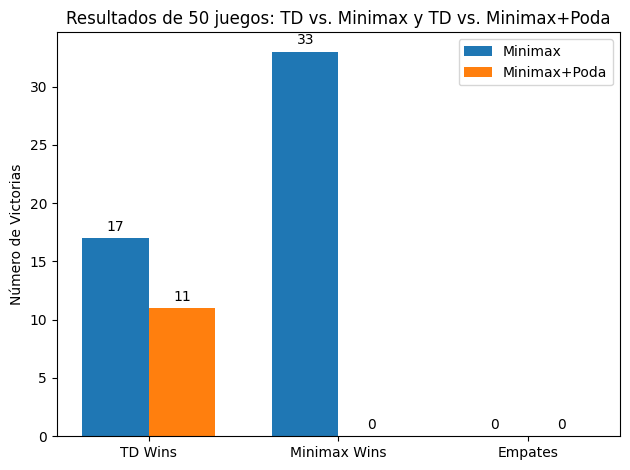

In [53]:
def evaluate_agents(num_games=50, depth=4):
    results_minimax = {"TD Wins": 0, "Minimax Wins": 0, "Empates": 0}
    results_alpha_beta = {"TD Wins": 0, "Minimax+Poda Wins": 0, "Empates": 0}

    # Simular juegos TD vs. Minimax sin poda
    for _ in range(num_games):
        result = simulate_game_td_vs_minimax(use_pruning=False, depth=depth)
        if result == 2:
            results_minimax["TD Wins"] += 1
        elif result == 1:
            results_minimax["Minimax Wins"] += 1
        else:
            results_minimax["Empates"] += 1

    # Simular juegos TD vs. Minimax con poda alpha-beta
    for _ in range(num_games):
        result = simulate_game_td_vs_minimax(use_pruning=True, depth=depth)
        if result == 2:
            results_alpha_beta["TD Wins"] += 1
        elif result == 1:
            results_alpha_beta["Minimax+Poda Wins"] += 1
        else:
            results_alpha_beta["Empates"] += 1

    return results_minimax, results_alpha_beta

def plot_results(results_minimax, results_alpha_beta):
    # Graficar resultados con matplotlib y guardar en PDF
    import matplotlib.pyplot as plt  # Asegúrate de importar matplotlib
    labels = list(results_minimax.keys())
    values_minimax = [results_minimax[label] for label in labels]
    values_alpha_beta = [results_alpha_beta.get(label, 0) for label in labels]

    x = np.arange(len(labels))  # posición de las etiquetas
    width = 0.35  # ancho de las barras

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, values_minimax, width, label='Minimax')
    rects2 = ax.bar(x + width/2, values_alpha_beta, width, label='Minimax+Poda')

    ax.set_ylabel('Número de Victorias')
    ax.set_title('Resultados de 50 juegos: TD vs. Minimax y TD vs. Minimax+Poda')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 puntos de desplazamiento
                    textcoords="offset points",
                    ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig("resultados.pdf")
    plt.show()

# Función que evalúa y grafica automáticamente
def evaluate_and_plot(num_games=50, depth=4):
    results_minimax, results_alpha_beta = evaluate_agents(num_games, depth)
    print("Resultados TD vs. Minimax (sin poda):", results_minimax)
    print("Resultados TD vs. Minimax (con poda):", results_alpha_beta)
    plot_results(results_minimax, results_alpha_beta)

# Llamada directa para evaluar y graficar:
evaluate_and_plot(num_games=50, depth=3)


### Fine Tuning

In [54]:
# ---------------- Fine Tuning ---------------- #
def fine_tuning():
    global ALPHA, GAMMA, EPSILON, EPSILON_DECAY, q_model
    print("Ajuste de parámetros del algoritmo TD Learning")
    new_alpha = input(f"Ingrese la tasa de aprendizaje (ALPHA) actual ({ALPHA}): ").strip()
    if new_alpha != "":
        ALPHA = float(new_alpha)
        # Reconstruir el modelo con el nuevo ALPHA
        q_model = build_model()
    new_gamma = input(f"Ingrese el factor de descuento (GAMMA) actual ({GAMMA}): ").strip()
    if new_gamma != "":
        GAMMA = float(new_gamma)
    new_epsilon = input(f"Ingrese la tasa de exploración (EPSILON) actual ({EPSILON}): ").strip()
    if new_epsilon != "":
        EPSILON = float(new_epsilon)
    new_decay = input(f"Ingrese el factor de decaimiento (EPSILON_DECAY) actual ({EPSILON_DECAY}): ").strip()
    if new_decay != "":
        EPSILON_DECAY = float(new_decay)
    print("Nuevos parámetros:")
    print(f"ALPHA = {ALPHA}, GAMMA = {GAMMA}, EPSILON = {EPSILON}, EPSILON_DECAY = {EPSILON_DECAY}")



### Menu de ejecucion


In [55]:

def ejecutar():
    print("=== Connect 4 con TD Learning ===")
    print("1. Entrenar agente")
    print("2. Jugar contra el agente entrenado")
    print("3. Evaluar agente automáticamente")
    print("4. Ajustar parámetros")
    print("5. Salir")
    
    opcion = input("Seleccione una opción (1-5): ").strip().lower()
    
    if opcion == "1":
        episodios = int(input("Número de episodios de entrenamiento: "))
        train_agent(episodios)
        ejecutar()
    elif opcion == "2":
        play_game()
        ejecutar()
    elif opcion == "3":
        evaluate_agents_automatic(depth=3)
        ejecutar()
    elif opcion == "4":
        fine_tuning()
        ejecutar()
    elif opcion == "5":
        print("¡Hasta luego!")
    else:
        print("Opción no válida. Intente de nuevo.")
        ejecutar()

ejecutar()


=== Connect 4 con TD Learning ===
1. Entrenar agente
2. Jugar contra el agente entrenado
3. Evaluar agente automáticamente
4. Ajustar parámetros
5. Salir
Episode 1/2 - Total Reward: 89 - Epsilon: 0.995
Episode 2/2 - Total Reward: 75 - Epsilon: 0.990
=== Connect 4 con TD Learning ===
1. Entrenar agente
2. Jugar contra el agente entrenado
3. Evaluar agente automáticamente
4. Ajustar parámetros
5. Salir
0 0 0 0 0 0 0 
0 0 0 0 0 0 0 
0 0 0 0 0 0 0 
0 0 0 0 0 0 0 
0 0 0 0 0 0 0 
0 0 0 0 0 0 0 

0 0 0 0 0 0 0 
0 0 0 0 0 0 0 
0 0 0 0 0 0 0 
0 0 0 0 0 0 0 
0 0 0 0 0 0 0 
0 0 0 0 0 1 0 

0 0 0 0 0 0 0 
0 0 0 0 0 0 0 
0 0 0 0 0 0 0 
0 0 0 0 0 0 0 
0 0 0 0 0 2 0 
0 0 0 0 0 1 0 

0 0 0 0 0 0 0 
0 0 0 0 0 0 0 
0 0 0 0 0 0 0 
0 0 0 0 0 0 0 
0 0 0 0 0 2 0 
0 1 0 0 0 1 0 

0 0 0 0 0 0 0 
0 0 0 0 0 0 0 
0 0 0 0 0 0 0 
0 0 0 0 0 0 0 
0 0 0 0 0 2 0 
0 1 2 0 0 1 0 

0 0 0 0 0 0 0 
0 0 0 0 0 0 0 
0 0 0 0 0 0 0 
0 0 0 0 0 0 0 
0 0 1 0 0 2 0 
0 1 2 0 0 1 0 

0 0 0 0 0 0 0 
0 0 0 0 0 0 0 
0 0 0 0 0 0 0 
0 0 2

# Referencias

- Juego de suma cero  Gana o pierda todo  Presentar juegos de suma cero en la teoria del juego - FasterCapital. (s. f.). FasterCapital. https://fastercapital.com/es/contenido/Juego-de-suma-cero--Gana-o-pierda-todo--Presentar-juegos-de-suma-cero-en-la-teoria-del-juego.html

- Alex. (s. f.). Teoría de juegos: Estrategia y toma de decisiones en situaciones competitivas. AproximadaMente. Pensar Mejor y Tomar Mejores Decisiones. https://www.aproximadamente.com/teoria-de-juegos%3A-estrategia-y-toma-de-decisiones-en-situaciones-competitivas/

- How can you use temporal difference learning in a reinforcement learning project? (2024, 8 enero). https://www.linkedin.com/advice/0/how-can-you-use-temporal-difference-learning-99ncc

- Cerretani, J. (2024, 20 diciembre). Aprendizaje por refuerzo (RL) — Capítulo 1: Historia del aprendizaje por refuerzo — Parte 3: Aprendizaje por diferencia temporal. Medium. https://medium.com/%40joancerretanids/aprendizaje-por-refuerzo-rl-cap%C3%ADtulo-1-historia-del-aprendizaje-por-refuerzo-parte-3-fc4d17197680

- Libretexts. (2022, 2 noviembre). 4: Juegos que no son de suma cero. LibreTexts Español. https://espanol.libretexts.org/Matematicas/Matematicas_Aplicadas/Introduccion_a_la_teoria_de_juegos%3A_un_enfoque_de_descubrimiento_%28Nordstrom%29/04%3A_Juegos_que_no_son_de_suma_cero
